In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import warnings
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, accuracy_score

In [2]:
# === Load and Normalize Dataset ===
data = pd.read_csv("D:\\Excel data\\Saliva\\Healthy (Control)\\CONTROL DATASET.csv")
X = data.values

# Optional: check shape
print("Original data shape:", data.shape)

Original data shape: (500, 3736)


In [3]:
# === Standar Scaler ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [4]:
# === Split Dataset ===
X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)

In [5]:
# === Apply PCA to Reduce Noise ===
pca = PCA(n_components=0.99, svd_solver='full')
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [6]:
# === Convert to Tensors ===
X_train_tensor = torch.tensor(X_train_pca, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_pca, dtype=torch.float32)

In [7]:
# Create DataLoader for training and testing 
batch_size = 16
train_loader = torch.utils.data.DataLoader(X_train_tensor, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(X_test_tensor, batch_size=batch_size, shuffle=False)

In [8]:
print("Training tensor shape:", X_train_tensor.shape)
print("Test tensor shape:", X_test_tensor.shape)

Training tensor shape: torch.Size([400, 19])
Test tensor shape: torch.Size([100, 19])


In [9]:
# === Define Autoencoder ===
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim=32):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [10]:
# === Training Setup ===
input_dim = X_train_pca.shape[1]
encoding_dim = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Autoencoder(input_dim, encoding_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

Epoch [1000/10000], Train Loss: 0.0154, Val Loss: 0.1025
Epoch [2000/10000], Train Loss: 0.0088, Val Loss: 0.1012
Epoch [3000/10000], Train Loss: 0.0094, Val Loss: 0.0895
Epoch [4000/10000], Train Loss: 0.0048, Val Loss: 0.0904
Epoch [5000/10000], Train Loss: 0.0053, Val Loss: 0.0875
Epoch [6000/10000], Train Loss: 0.0019, Val Loss: 0.0853
Epoch [7000/10000], Train Loss: 0.0117, Val Loss: 0.0951
Epoch [8000/10000], Train Loss: 0.0029, Val Loss: 0.0865
Epoch [9000/10000], Train Loss: 0.0015, Val Loss: 0.0841
Epoch [10000/10000], Train Loss: 0.0042, Val Loss: 0.0872


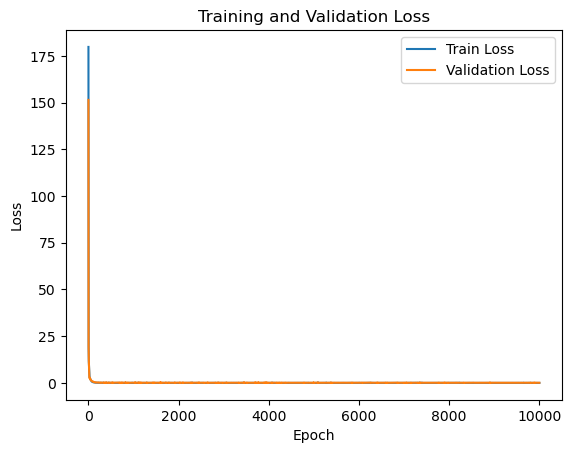

In [11]:
# === Training Loop ===
num_epochs = 10000
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        inputs = batch.to(device)
        optimizer.zero_grad()
        _, outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))

    # === Validation ===
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            inputs = batch.to(device)
            _, outputs = model(inputs)
            val_loss += criterion(outputs, inputs).item()
    val_losses.append(val_loss / len(test_loader))

    # === Print Progress ===
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

# === Plot Loss Curves ===
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [12]:
# === Generate Synthetic Data ===
model.eval()
n_samples = 500
latent_dim = encoding_dim

latent_samples = torch.randn(n_samples, latent_dim).to(device)
with torch.no_grad():
    synthetic_decoded = model.decoder(latent_samples)

synthetic_decoded_np = synthetic_decoded.cpu().numpy()
synthetic_original_space = pca.inverse_transform(synthetic_decoded_np)
synthetic_data = scaler.inverse_transform(synthetic_original_space)

print("Synthetic data shape:", synthetic_data.shape)

Synthetic data shape: (500, 3736)


In [13]:
# Reload real data to get column names
real_data = pd.read_csv('D:\\Excel data\\Saliva\\Healthy (Control)\\CONTROL DATASET.csv')

# Create a DataFrame for the synthetic data with correct columns
synthetic_df = pd.DataFrame(synthetic_data, columns=real_data.columns)

# Save to CSV
synthetic_df.to_csv('C:\\Users\\Ahmed\\Final\\synthetic_data_AE_LiR.csv', index=False)

print("✅ 500 synthetic samples generated and saved successfully!")

✅ 500 synthetic samples generated and saved successfully!


In [14]:
print("X_train shape:", X_train.shape)
print("synthetic_data shape:", synthetic_data.shape)
print("Total elements in X_train:", X_train.size)
print("Total elements in synthetic_data:", synthetic_data.size)

X_train shape: (400, 3736)
synthetic_data shape: (500, 3736)
Total elements in X_train: 1494400
Total elements in synthetic_data: 1868000


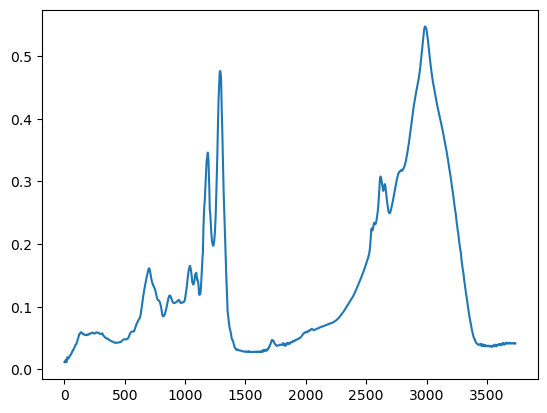

In [15]:
plt.plot(synthetic_data[20,:])

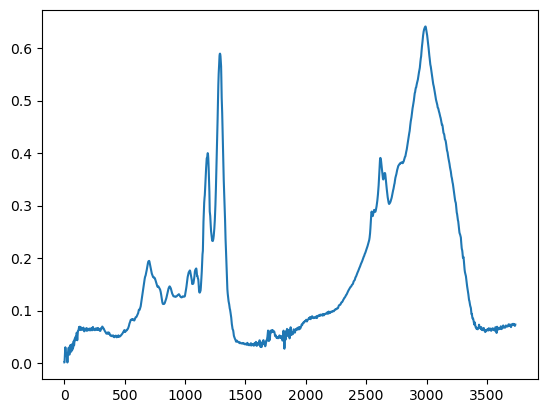

In [16]:
plt.plot(X[20,:])

In [17]:
Y = pd.read_csv('C:\\Users\\Ahmed\\Final\\synthetic_data_AE_LiR.csv')  

In [18]:
print (Y)

     Wavelenght399  Wavelenght400  Wavelenght401  Wavelenght402  \
0         0.015029       0.015385       0.015491       0.015447   
1         0.009892       0.012645       0.015513       0.017896   
2         0.013084       0.013757       0.014096       0.014042   
3         0.009531       0.009733       0.010152       0.010644   
4         0.010386       0.011164       0.011712       0.011892   
..             ...            ...            ...            ...   
495       0.012823       0.013595       0.013492       0.013005   
496       0.009917       0.011790       0.013552       0.014927   
497       0.013828       0.014049       0.013884       0.013614   
498       0.012880       0.013541       0.013768       0.013742   
499       0.011117       0.011314       0.011160       0.010857   

     Wavelenght403  Wavelenght404  Wavelenght405  Wavelenght406  \
0         0.015328       0.015218       0.015228       0.015471   
1         0.019541       0.020397       0.020540       0.0201

In [19]:
data_fake = Y

In [20]:
data_fake.head()

,Wavelenght399,Wavelenght400,Wavelenght401,Wavelenght402,Wavelenght403,Wavelenght404,Wavelenght405,Wavelenght406,Wavelenght407,Wavelenght408,...,Wavelenght4125,Wavelenght4126,Wavelenght4127,Wavelenght4128,Wavelenght4129,Wavelenght4130,Wavelenght4131,Wavelenght4132,Wavelenght4133,Wavelenght4134
0,0.015029,0.015385,0.015491,0.015447,0.015328,0.015218,0.015228,0.015471,0.016001,0.016756,...,0.041712,0.041665,0.041626,0.041567,0.041460,0.041306,0.041151,0.041063,0.041083,0.041534
1,0.009892,0.012645,0.015513,0.017896,0.019541,0.020397,0.020540,0.020137,0.019405,0.018520,...,0.040435,0.040265,0.040073,0.039884,0.039693,0.039503,0.039348,0.039277,0.039326,0.039758
2,0.013084,0.013757,0.014096,0.014042,0.013755,0.013522,0.013636,0.014260,0.015291,0.016356,...,0.041966,0.041804,0.041676,0.041579,0.041478,0.041357,0.041247,0.041203,0.041264,0.041758
3,0.009531,0.009733,0.010152,0.010644,0.011156,0.011744,0.012529,0.013612,0.014942,0.016258,...,0.041015,0.040863,0.040770,0.040740,0.040735,0.040719,0.040683,0.040654,0.040660,0.041032
4,0.010386,0.011164,0.011712,0.011892,0.011846,0.011912,0.012465,0.013710,0.015498,0.017320,...,0.041222,0.041117,0.041043,0.040981,0.040887,0.040749,0.040606,0.040517,0.040520,0.040942


In [21]:
pip install --upgrade table_evaluator

Note: you may need to restart the kernel to use updated packages.


In [22]:
data_fake.shape

(500, 3736)

In [23]:
from table_evaluator import load_data, TableEvaluator

In [24]:
real, fake = load_data('D:\\Excel data\\Saliva\\Healthy (Control)\\CONTROL DATASET.csv', 'C:\\Users\\Ahmed\\Final\\synthetic_data_AE_LiR.csv')

In [25]:
real.head()

,Wavelenght399,Wavelenght400,Wavelenght401,Wavelenght402,Wavelenght403,Wavelenght404,Wavelenght405,Wavelenght406,Wavelenght407,Wavelenght408,...,Wavelenght4125,Wavelenght4126,Wavelenght4127,Wavelenght4128,Wavelenght4129,Wavelenght4130,Wavelenght4131,Wavelenght4132,Wavelenght4133,Wavelenght4134
0,0.002788,0.002679,0.002590,0.002397,0.002003,0.001440,0.001000,0.001180,0.002424,0.004826,...,0.055228,0.055092,0.054975,0.054888,0.054804,0.054691,0.054528,0.054321,0.054095,0.055661
1,0.011223,0.008644,0.005475,0.002793,0.001204,0.001000,0.002254,0.004759,0.007979,0.011209,...,0.061770,0.061952,0.062080,0.062084,0.061915,0.061576,0.061120,0.060638,0.060233,0.061807
2,0.008241,0.005308,0.002601,0.001042,0.001000,0.002507,0.005380,0.009190,0.013286,0.016967,...,0.074086,0.074106,0.074020,0.073812,0.073489,0.073087,0.072667,0.072293,0.072012,0.073635
3,0.004690,0.002150,0.001000,0.001314,0.002725,0.004786,0.006996,0.008779,0.009587,0.009128,...,0.048002,0.047823,0.047553,0.047284,0.047106,0.047079,0.047209,0.047450,0.047716,0.048322
4,-0.000024,0.001000,0.001965,0.002710,0.003198,0.003527,0.003874,0.004343,0.004843,0.005093,...,0.028844,0.028710,0.028535,0.028377,0.028270,0.028223,0.028226,0.028253,0.028278,0.028715


In [26]:
fake.head()

,Wavelenght399,Wavelenght400,Wavelenght401,Wavelenght402,Wavelenght403,Wavelenght404,Wavelenght405,Wavelenght406,Wavelenght407,Wavelenght408,...,Wavelenght4125,Wavelenght4126,Wavelenght4127,Wavelenght4128,Wavelenght4129,Wavelenght4130,Wavelenght4131,Wavelenght4132,Wavelenght4133,Wavelenght4134
0,0.015029,0.015385,0.015491,0.015447,0.015328,0.015218,0.015228,0.015471,0.016001,0.016756,...,0.041712,0.041665,0.041626,0.041567,0.041460,0.041306,0.041151,0.041063,0.041083,0.041534
1,0.009892,0.012645,0.015513,0.017896,0.019541,0.020397,0.020540,0.020137,0.019405,0.018520,...,0.040435,0.040265,0.040073,0.039884,0.039693,0.039503,0.039348,0.039277,0.039326,0.039758
2,0.013084,0.013757,0.014096,0.014042,0.013755,0.013522,0.013636,0.014260,0.015291,0.016356,...,0.041966,0.041804,0.041676,0.041579,0.041478,0.041357,0.041247,0.041203,0.041264,0.041758
3,0.009531,0.009733,0.010152,0.010644,0.011156,0.011744,0.012529,0.013612,0.014942,0.016258,...,0.041015,0.040863,0.040770,0.040740,0.040735,0.040719,0.040683,0.040654,0.040660,0.041032
4,0.010386,0.011164,0.011712,0.011892,0.011846,0.011912,0.012465,0.013710,0.015498,0.017320,...,0.041222,0.041117,0.041043,0.040981,0.040887,0.040749,0.040606,0.040517,0.040520,0.040942


In [27]:
# Apply the classifier

# === Suppress warnings ===
warnings.simplefilter(action='ignore', category=FutureWarning)

# === Label datasets ===
real['label_binary'] = 0  # Real
fake['label_binary'] = 1  # Synthetic

# === Combine datasets ===
combined = pd.concat([real, fake], ignore_index=True)
combined = combined.sample(frac=1, random_state=42).reset_index(drop=True)

# === Split into features and label ===
X = combined.drop(columns=['label_binary'])
y = combined['label_binary']

# === Standardize features (optional but often useful) ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === Train/test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

C:\Users\Ahmed\AppData\Local\Temp\ipykernel_19540\283008972.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fake['label_binary'] = 1  # Synthetic


In [28]:
# === Logistic Regression for binary target ===
clf = LogisticRegression(max_iter=1000)  
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# === Evaluate binary classification ===
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

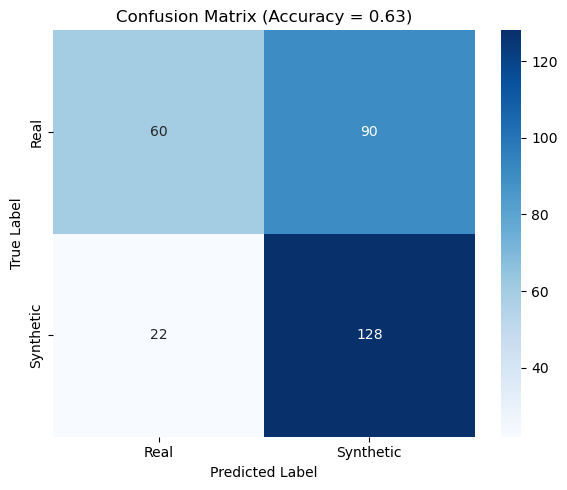

Accuracy:  0.6267
Precision: 0.5872
Recall:    0.8533
F1 Score:  0.6957


In [29]:
# === Display Confusion Matrix ===
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Real", "Synthetic"],
            yticklabels=["Real", "Synthetic"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix (Accuracy = {accuracy:.2f})")
plt.tight_layout()
plt.show()

# === Print metrics ===
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

C:\Users\Ahmed\AppData\Local\Temp\ipykernel_19540\2283032126.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fake['label_continuous'] = fake['Wavelenght399']


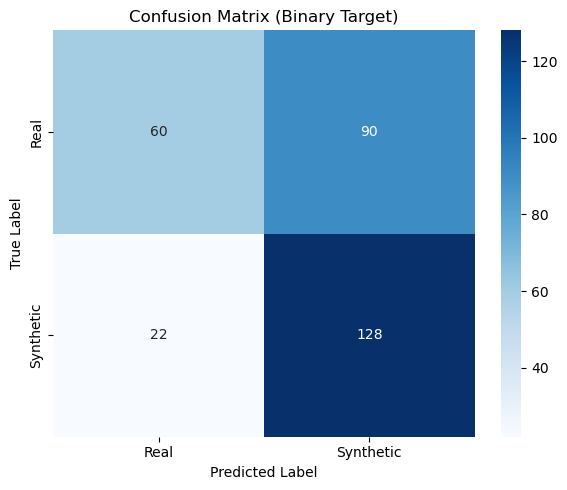

Binary Classification Metrics:
Accuracy:  0.63
Precision: 0.59
Recall:    0.85
F1 Score:  0.70


In [35]:
# 10-fold cross validation

# === Label datasets ===
real['label_binary'] = 0  # Real
fake['label_binary'] = 1  # Synthetic

# Add dummy continuous target (you can change this to any real column)
real['label_continuous'] = real['Wavelenght399']
fake['label_continuous'] = fake['Wavelenght399']

# === Combine datasets ===
combined = pd.concat([real, fake], ignore_index=True)
combined = combined.sample(frac=1, random_state=42).reset_index(drop=True)

# === Split into features and labels ===
X = combined.drop(columns=['label_binary', 'label_continuous'])
y_bin = combined['label_binary']
y_cont = combined['label_continuous']

# === Standardize features ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === Train/test split ===
X_train, X_test, y_train, y_test, y_cont_train, y_cont_test = train_test_split(
    X_scaled, y_bin, y_cont, test_size=0.3, random_state=42, stratify=y_bin
)

# === Logistic Regression for binary target ===
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# === Evaluate binary classification ===
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# === Display Confusion Matrix ===
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Real", "Synthetic"],
            yticklabels=["Real", "Synthetic"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix (Binary Target)")
plt.tight_layout()
plt.show()

# === Print classification metrics ===
print("Binary Classification Metrics:")
print(f"Accuracy:  {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1 Score:  {f1:.2f}")

In [37]:
# === 10-Fold Cross-Validation for Classification ===
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Use X_train and y_train for cross-validation, not the entire dataset
cv_accuracy = cross_val_score(clf, X_train, y_train, cv=kfold, scoring='accuracy')
cv_f1 = cross_val_score(clf, X_train, y_train, cv=kfold, scoring='f1')
cv_precision = cross_val_score(clf, X_train, y_train, cv=kfold, scoring='precision')
cv_recall = cross_val_score(clf, X_train, y_train, cv=kfold, scoring='recall')

print("\n10-Fold Cross-Validation (Classification):")
print(f"Average Accuracy: {cv_accuracy.mean():.2f} ± {cv_accuracy.std():.2f}")
print(f"Average F1 Score: {cv_f1.mean():.2f} ± {cv_f1.std():.2f}")
print(f"Average Precision: {cv_precision.mean():.2f} ± {cv_precision.std():.2f}")
print(f"Average Recall: {cv_recall.mean():.2f} ± {cv_recall.std():.2f}")

# === Linear Regression for continuous target ===
reg = LinearRegression()
reg.fit(X_train, y_cont_train)
y_cont_pred = reg.predict(X_test)

# === Evaluate regression ===
mse = mean_squared_error(y_cont_test, y_cont_pred)
print("\nContinuous Target Regression Metrics:")
print(f"Mean Squared Error: {mse:.2f}")

# === 10-Fold Cross-Validation for Regression ===
cv_mse = cross_val_score(reg, X_train, y_cont_train, cv=kfold, scoring='neg_mean_squared_error')
cv_mse_mean = -cv_mse.mean()
cv_mse_std = cv_mse.std()

print("\n10-Fold Cross-Validation (Regression):")
print(f"Average MSE: {cv_mse_mean:.2f} ± {cv_mse_std:.2f}")


10-Fold Cross-Validation (Classification):
Average Accuracy: 0.67 ± 0.04
Average F1 Score: 0.73 ± 0.04
Average Precision: 0.62 ± 0.05
Average Recall: 0.88 ± 0.05

Continuous Target Regression Metrics:
Mean Squared Error: 0.00

10-Fold Cross-Validation (Regression):
Average MSE: 0.00 ± 0.00


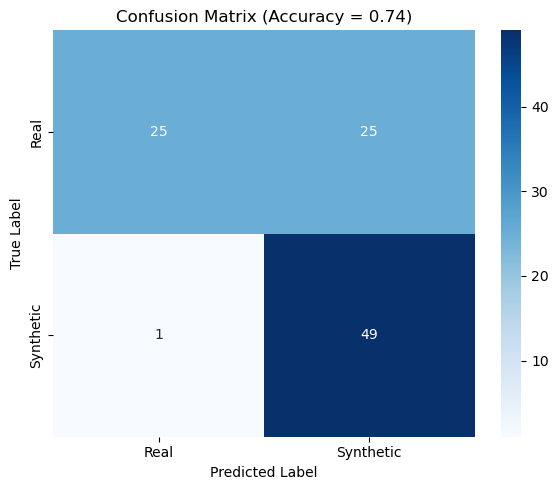

Binary Classification Metrics:
Accuracy:  0.7400
Precision: 0.6622
Recall:    0.9800
F1 Score:  0.7903

Continuous Regression Metrics:
Mean Squared Error: 0.0000


In [39]:
# Mixed the Real and the fake data, took 50% of each dataset, and combined them. 


# === Load datasets ===
real_data = pd.read_csv('D:\\Excel data\\Saliva\\Healthy (Control)\\CONTROL DATASET.csv')
fake_data = pd.read_csv('C:\\Users\\Ahmed\\Final\\synthetic_data_AE_LiR.csv')

# === Take 50% from each dataset ===
real_sample = real_data.sample(frac=0.5, random_state=42)
fake_sample = fake_data.sample(frac=0.5, random_state=42)

# === Label the datasets ===
real_sample['label'] = 0  # Real
fake_sample['label'] = 1  # Synthetic

# === Combine datasets ===
combined_data = pd.concat([real_sample, fake_sample], ignore_index=True)
combined_data = combined_data.sample(frac=1, random_state=42).reset_index(drop=True)

# === Identify continuous target ===
# Assuming 'Wavelenght399' is your continuous target (replace this with the correct column name)
continuous_target_col = 'Wavelenght399'  # <-- Update this to your continuous target column!
features = combined_data.drop(['label', continuous_target_col], axis=1)  # Dropping the label and target
y_bin = combined_data['label']
y_cont = combined_data[continuous_target_col]

# === Standardize features ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# === Train/Test Split ===
X_train, X_test, y_bin_train, y_bin_test, y_cont_train, y_cont_test = train_test_split(
    X_scaled, y_bin, y_cont, test_size=0.2, stratify=y_bin, random_state=42
)

# === Logistic Regression for Binary Target ===
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_bin_train)
y_bin_pred = clf.predict(X_test)

# === Evaluation - Binary Classification ===
conf_matrix = confusion_matrix(y_bin_test, y_bin_pred)
accuracy = accuracy_score(y_bin_test, y_bin_pred)
precision = precision_score(y_bin_test, y_bin_pred)
recall = recall_score(y_bin_test, y_bin_pred)
f1 = f1_score(y_bin_test, y_bin_pred)

# === Display Confusion Matrix ===
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Real", "Synthetic"],
            yticklabels=["Real", "Synthetic"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix (Accuracy = {accuracy:.2f})")
plt.tight_layout()
plt.show()

# === Print Binary Classification Metrics ===
print("Binary Classification Metrics:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# === Linear Regression for Continuous Target ===
reg = LinearRegression()
reg.fit(X_train, y_cont_train)
y_cont_pred = reg.predict(X_test)

# === Evaluation - Continuous Target ===
mse = mean_squared_error(y_cont_test, y_cont_pred)
print("\nContinuous Regression Metrics:")
print(f"Mean Squared Error: {mse:.4f}")